In [1]:
import numpy as np
import pandas as pd
import sys

from copy import deepcopy
from tqdm.auto import tqdm, trange

In [2]:
from IPython.display import SVG, display
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline 
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/deep-stpp/notebooks

sys.path.append("/content/drive/MyDrive/deep-stpp/src")
from data.synthetic import *
from plotter import *

/content/drive/MyDrive/deep-stpp/notebooks


In [4]:
def summarize(data):
    print(f'number of data: {len(data)}')
    
    seq_lens = [len(seq) for seq in data]
    print(f'sequence length range: {min(seq_lens)} ~ {max(seq_lens)}')
    
    ranges = []
    for i in range(3):
        start = min([seq[0, i]  for seq in data])
        end   = max([seq[-1, i] for seq in data])
        ranges.append((start, end))

    print(f'time range: {ranges[0][0]:.3f} ~ {ranges[0][1]:.3f}')
    print(f's1 range:   {ranges[1][0]:.3f} ~ {ranges[1][1]:.3f}')
    print(f's2 range:   {ranges[2][0]:.3f} ~ {ranges[2][1]:.3f}')
        
    fig = go.Figure(data=[go.Histogram(x=seq_lens, histnorm='probability', name='Sequence Lengths')])
    fig.show()

---
## Earthquake Japan Dataset

In [8]:
dataset = np.load('../data/interim/earthquakes_jp.npz')
exclude_from_train = (dataset.files[::30] + dataset.files[1::30] + dataset.files[2::30] + dataset.files[3::30]
                      + dataset.files[4::30] + dataset.files[5::30] + dataset.files[6::30] + dataset.files[7::30]
                      + dataset.files[8::30] + dataset.files[9::30] + dataset.files[10::30])
val_files = dataset.files[3::30]
test_files = dataset.files[7::30]
train_files = list(set(dataset.files).difference(exclude_from_train))
file_splits = {"train": train_files, "val": val_files, "test": test_files}

In [9]:
for key, value in file_splits.items():
    print(f'{key} set contains {len(value)} sequences')

train set contains 950 sequences
val set contains 50 sequences
test set contains 50 sequences


In [16]:
data = [dataset[f] for f in train_files + test_files + val_files]
summarize(data)

number of data: 1050
sequence length range: 19 ~ 545
time range: 0.000 ~ 30.000
s1 range:   122.317 ~ 146.661
s2 range:   22.061 ~ 45.939


In [ ]:
with open('../data/processed/earthquakes_jp.npz', 'wb') as f:
    np.savez(f, 
             train=[dataset[f] for f in train_files],
             test =[dataset[f] for f in test_files],
             val  =[dataset[f] for f in val_files],)

/home/ziz244/miniconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



---
## COVID-19 NY Dataset

In [17]:
dataset = np.load("../data/interim/covid_nj_cases.npz")
dates = dict()
for f in dataset.files:
    dates[f[:8]] = 1
dates = list(dates.keys())
exclude_from_train = (dates[::27] + dates[1::27] + dates[2::27]
                              + dates[3::27] + dates[4::27] + dates[5::27]
                              + dates[6::27] + dates[7::27])
val_dates = dates[2::27]
test_dates = dates[5::27]
train_dates = set(dates).difference(exclude_from_train)
date_splits = {"train": train_dates, "val": val_dates, "test": test_dates}

d2f = lambda dates : [f for f in dataset.files if f[:8] in dates]

val_files, test_files, train_files = d2f(val_dates), d2f(test_dates), d2f(train_dates)
file_splits = {"train": train_files, "val": val_files, "test": test_files}

for key, value in file_splits.items():
    print(f'{key} set contains {len(value)} sequences')

train set contains 1450 sequences
val set contains 100 sequences
test set contains 100 sequences


number of data: 1650
sequence length range: 7 ~ 305
time range: 0.000 ~ 7.000
s1 range:   -75.528 ~ -73.793
s2 range:   38.811 ~ 41.195


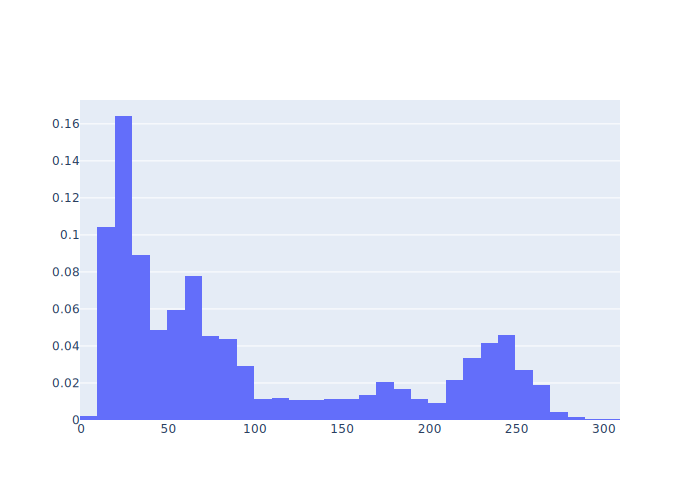

In [ ]:
data = [dataset[f] for f in train_files + test_files + val_files]
summarize(data)

In [ ]:
with open('../data/processed/covid_nj_cases.npz', 'wb') as f:
    np.savez(f, 
             train=[dataset[f] for f in train_files],
             test =[dataset[f] for f in test_files],
             val  =[dataset[f] for f in val_files],)

## Synthetic Dataset

### STSCP

In [35]:
def synthetic_split(his_s, his_t, T=40):
    his_ts = []
    his_t_new = []
    his_s_new = []
    
    sizes = []
    last_N = -1
    for s, t in zip(his_s, his_t):
        N = int(t // T)
        if N > last_N:
            if N > 0:
                his_ts.append(np.hstack((np.expand_dims(his_t_new[-1], -1), his_s_new[-1])))
            his_t_new.append([])
            his_s_new.append([])
        last_N = N
        his_t_new[-1].append(t % T)
        his_s_new[-1].append(s)
    his_ts.append(np.hstack((np.expand_dims(his_t_new[-1], -1), his_s_new[-1])))

    return his_ts


In [22]:
stscp0 = STSCPDataset(g0_cov = np.array([[1, 0],
                                         [0, 1]]),
                      g2_cov = np.array([[.85, 0],
                                         [0, .85]]),
                      alpha = .2, beta = .2, mu = 1, gamma = 0,
                      x_num = 101, y_num = 101,
                      max_history=100, dist_only=False)

stscp0.load('../data/raw/synthetic/stscp0.data', t_start=0, t_end=10000)

0it [00:00, ?it/s]

In [23]:
stscp1 = STSCPDataset(g0_cov = np.array([[.4, 0],
                                         [0, .4]]),
                      g2_cov = np.array([[.3, 0],
                                         [0, .3]]),
                      alpha = .3, beta = .2, mu = 1, gamma = 0,
                      x_num = 101, y_num = 101, lamb_max = 4, 
                      max_history=100, dist_only=False)

stscp1.load('../data/raw/synthetic/stscp1.data', t_start=0, t_end=10000)

0it [00:00, ?it/s]

In [24]:
stscp2 = STSCPDataset(g0_cov = np.array([[.25, 0],
                                         [0, .25]]),
                      g2_cov = np.array([[.2, 0],
                                         [0, .2]]),
                      alpha = .4, beta = .2, mu = 1, gamma = 0,
                      x_num = 101, y_num = 101,
                      max_history=100, dist_only=False)

stscp2.load('../data/raw/synthetic/stscp2.data', t_start=0, t_end=10000)

0it [00:00, ?it/s]

In [25]:
lambs0, x_range, y_range, t_range = stscp0.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=100)
print(x_range[0], x_range[-1])
print(y_range[0], y_range[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

0.0 1.0
0.0 1.0


In [26]:
with open('../data/external/stscp0_gt.npz', 'wb') as f:
    np.savez(f, 
             lambs  =lambs0,
             x_range=x_range,
             y_range=y_range,
             t_range=t_range)

  0%|          | 0/200 [00:00<?, ?it/s]

Inferred cmax: 2.6


  0%|          | 0/203 [00:00<?, ?it/s]

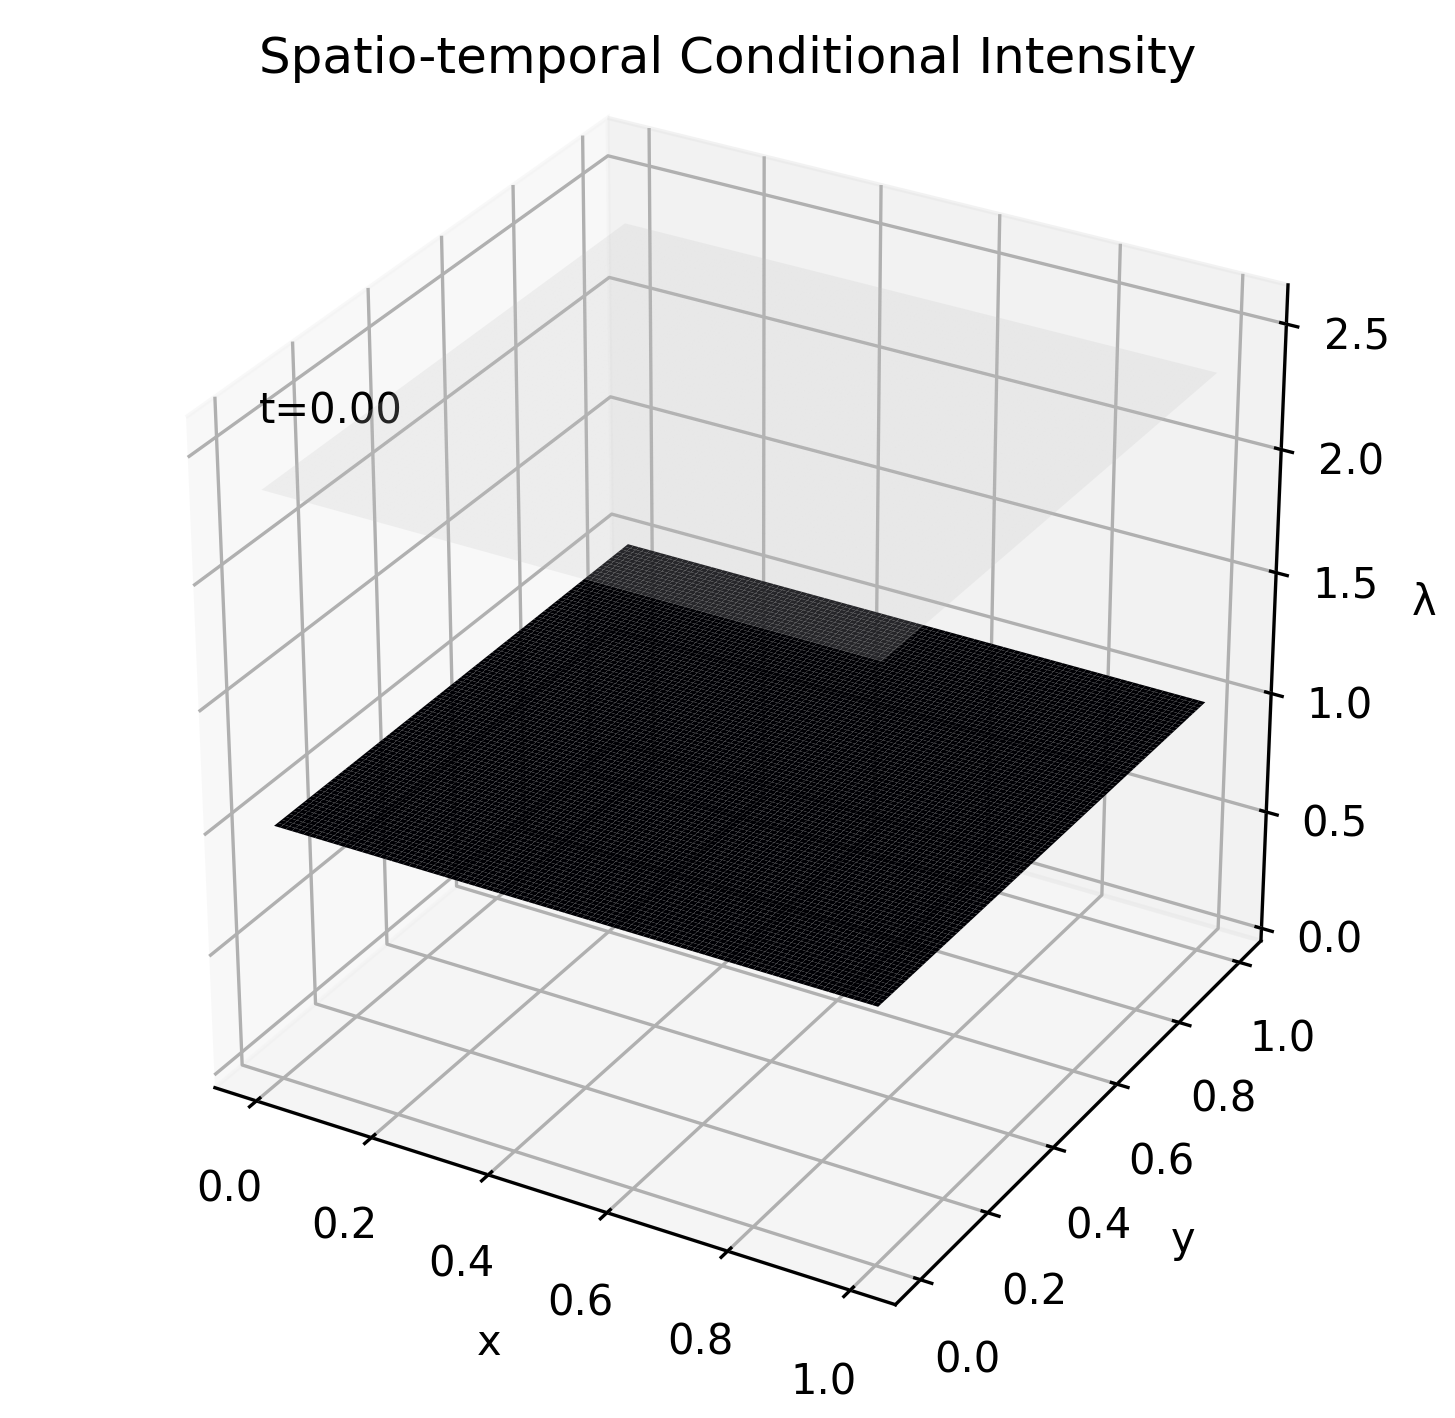

In [22]:
lambs0, x_range, y_range, t_range = stscp0.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=100)
plot_lambst_static(lambs0, x_range, y_range, t_range, history=(stscp0.his_s, stscp0.his_t), fn=f'../video/stscp0_gt.mp4', cmax=2.6, fps=12)

In [27]:
lambs1, x_range, y_range, t_range = stscp1.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=100)
print(x_range[0], x_range[-1])
print(y_range[0], y_range[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

0.0 1.0
0.0 1.0


In [28]:
with open('../data/external/stscp1_gt.npz', 'wb') as f:
    np.savez(f, 
             lambs  =lambs1,
             x_range=x_range,
             y_range=y_range,
             t_range=t_range)

  0%|          | 0/200 [00:00<?, ?it/s]

Inferred cmax: 3.2


  0%|          | 0/203 [00:00<?, ?it/s]

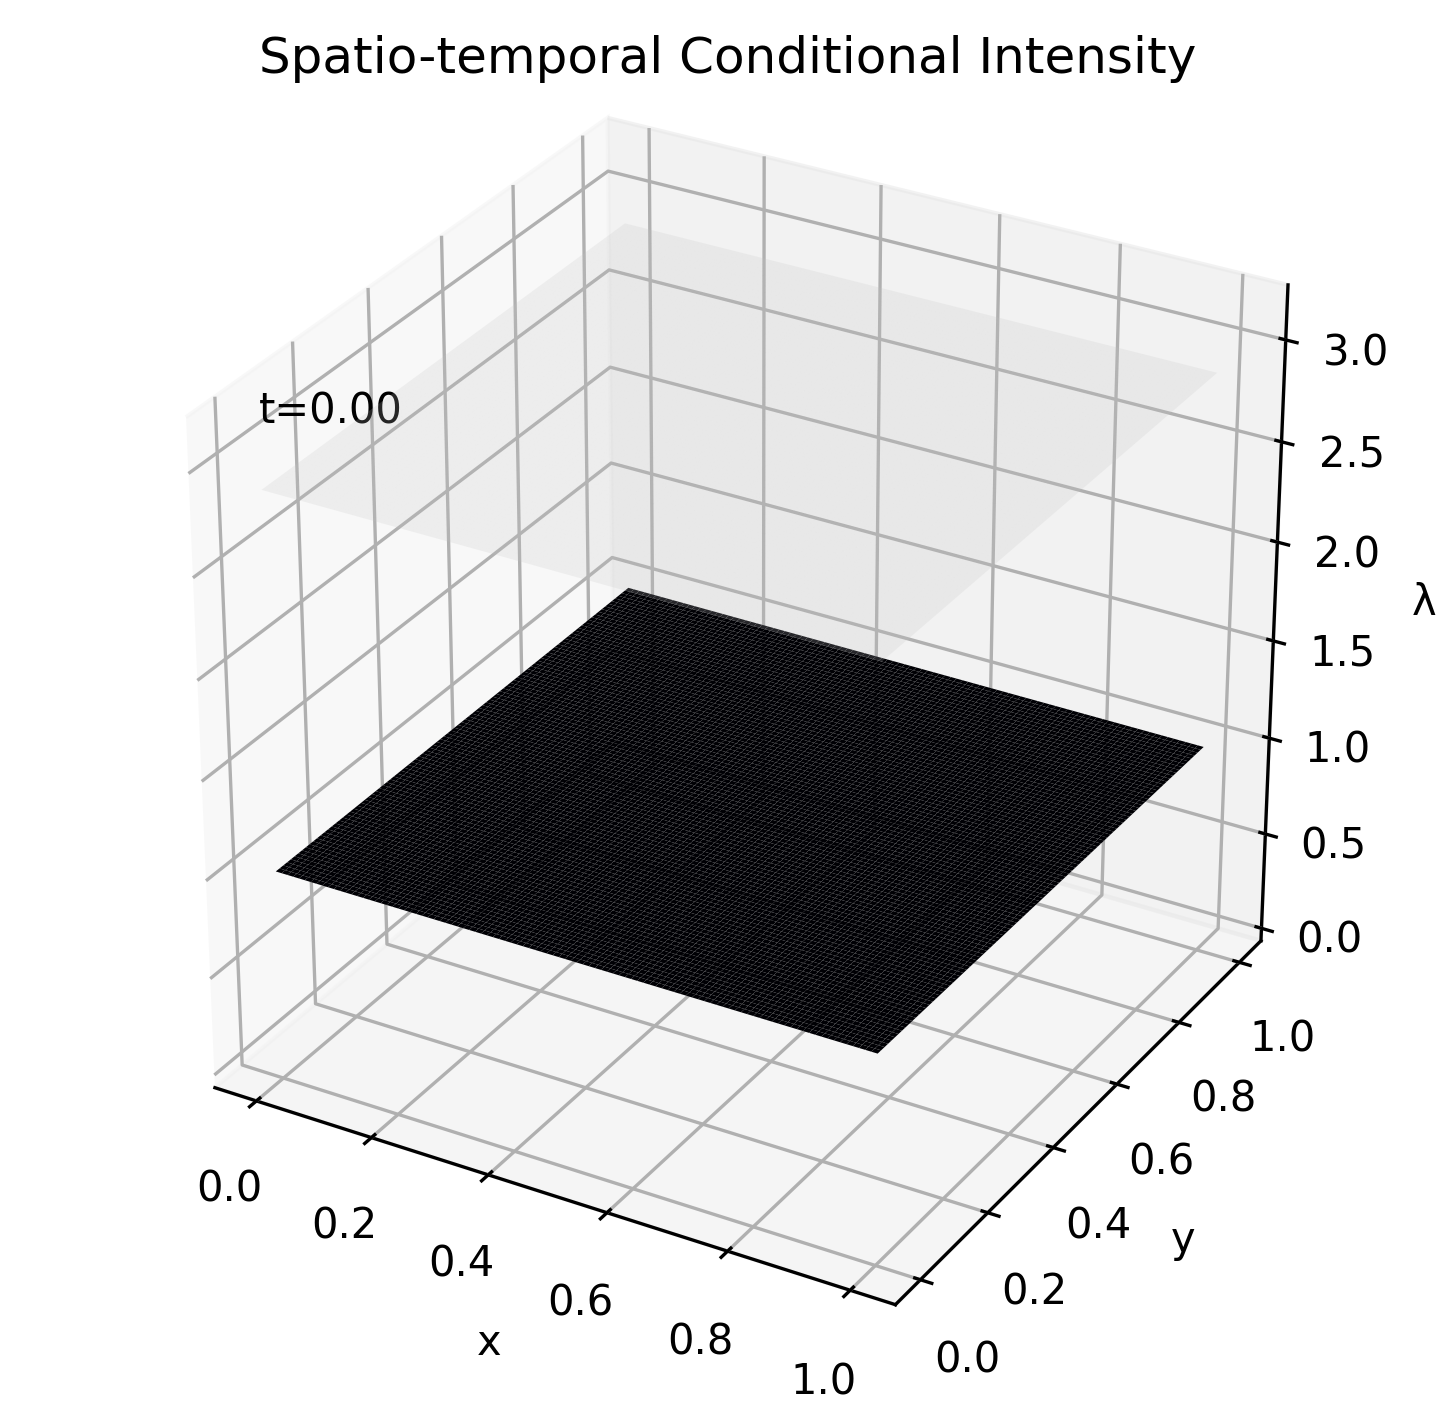

In [23]:
lambs1, x_range, y_range, t_range = stscp1.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=100)
plot_lambst_static(lambs1, x_range, y_range, t_range, history=(stscp1.his_s, stscp1.his_t), fn=f'../video/stscp1_gt.mp4', cmax=3.2, fps=12)

In [29]:
lambs2, x_range, y_range, t_range = stscp2.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=100)
print(x_range[0], x_range[-1])
print(y_range[0], y_range[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

0.04 0.98
0.04 1.0


In [30]:
with open('../data/external/stscp2_gt.npz', 'wb') as f:
    np.savez(f, 
             lambs  =lambs2,
             x_range=x_range,
             y_range=y_range,
             t_range=t_range)

  0%|          | 0/200 [00:00<?, ?it/s]

Inferred cmax: 3.5


  0%|          | 0/203 [00:00<?, ?it/s]

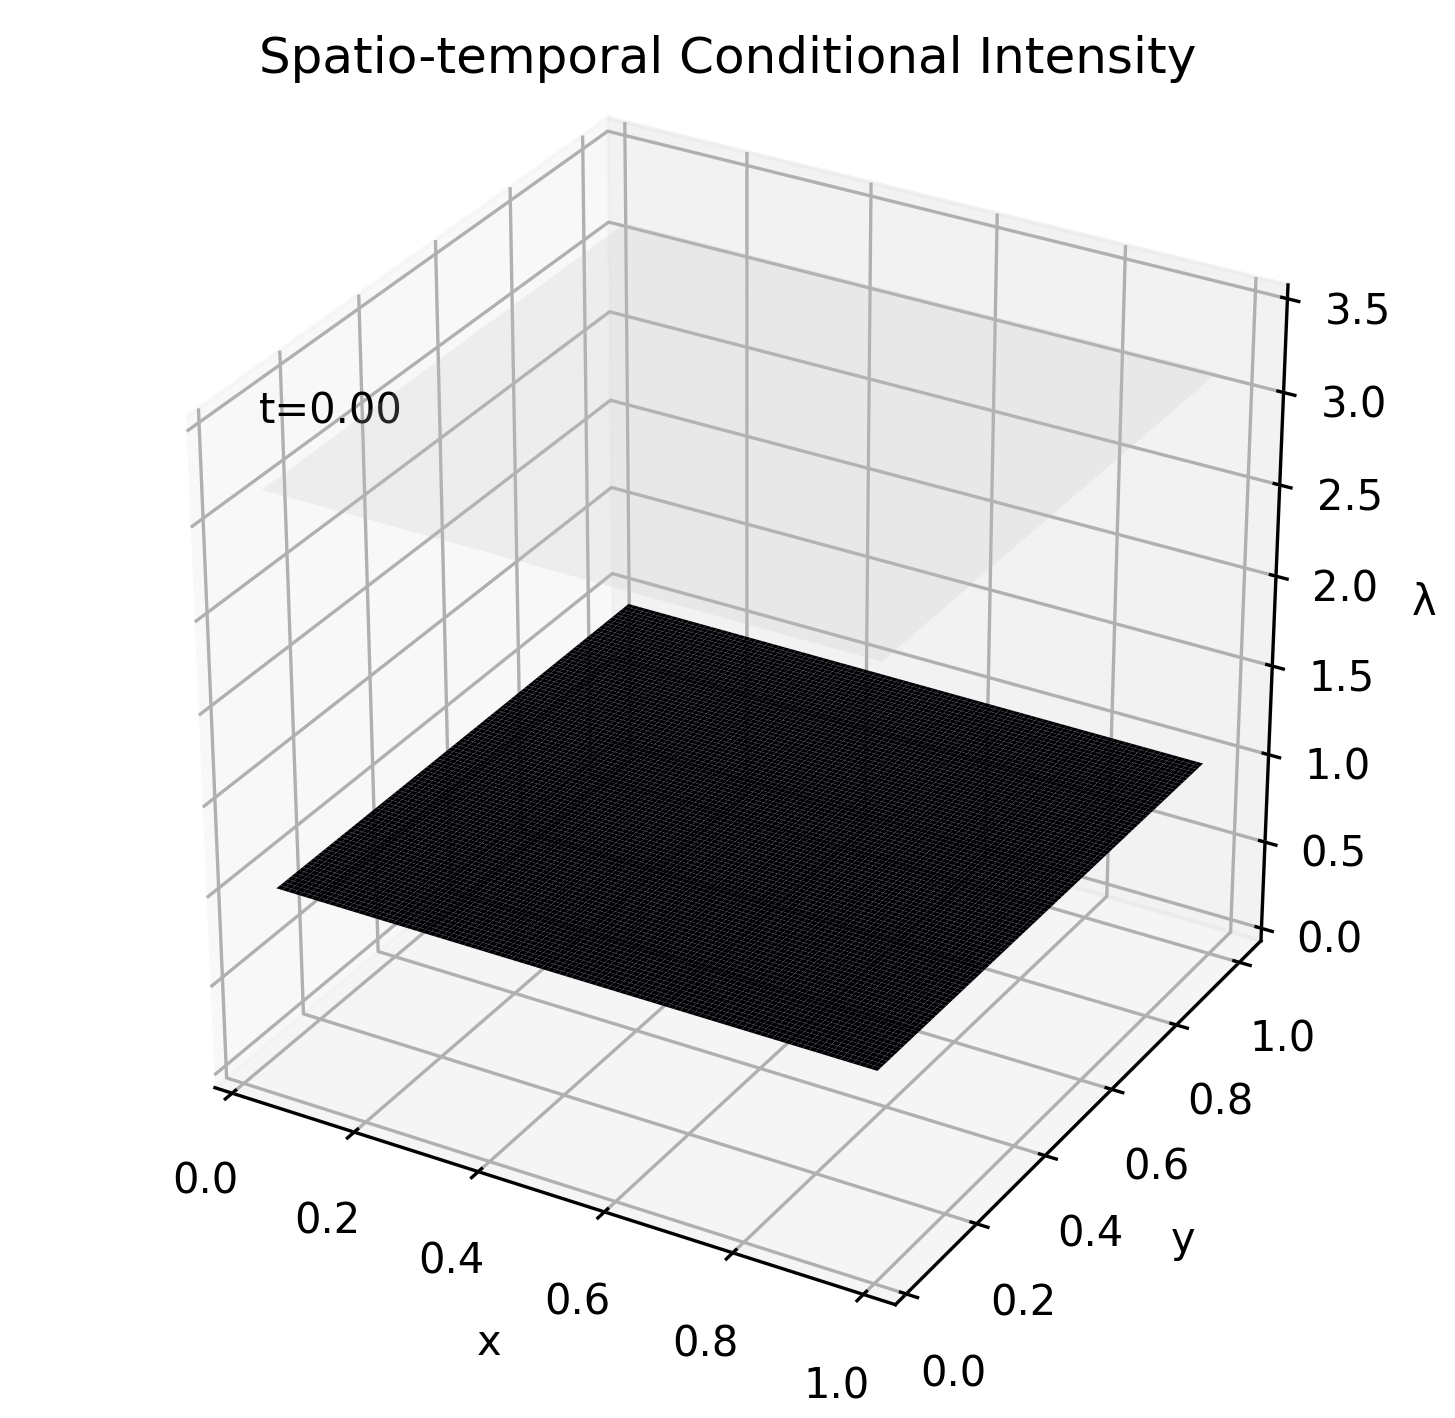

In [24]:
lambs2, x_range, y_range, t_range = stscp2.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=100)
plot_lambst_static(lambs2, x_range, y_range, t_range, history=(stscp2.his_s, stscp2.his_t), fn=f'../video/stscp2_gt.mp4', cmax=3.5, fps=12)

In [133]:
data = synthetic_split(stscp0.his_s, stscp0.his_t, T=100)
with open('../data/processed/stscp0.npz', 'wb') as f:
    np.savez(f, 
             train=data[20:100],
             test =data[0:10],
             val  =data[10:20])
summarize(data)

number of data: 100
sequence length range: 93 ~ 109
time range: 0.007 ~ 99.998
s1 range:   0.000 ~ 1.000
s2 range:   0.000 ~ 1.000


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [134]:
data = synthetic_split(stscp1.his_s, stscp1.his_t, T=100)
with open('../data/processed/stscp1.npz', 'wb') as f:
    np.savez(f, 
             train=data[20:100],
             test =data[0:10],
             val  =data[10:20])
summarize(data)

number of data: 100
sequence length range: 63 ~ 70
time range: 0.022 ~ 99.994
s1 range:   0.010 ~ 0.990
s2 range:   0.000 ~ 0.990


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [135]:
data = synthetic_split(stscp2.his_s, stscp2.his_t, T=100)
with open('../data/processed/stscp2.npz', 'wb') as f:
    np.savez(f, 
             train=data[20:100],
             test =data[0:10],
             val  =data[10:20])
summarize(data)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



number of data: 100
sequence length range: 45 ~ 53
time range: 0.001 ~ 99.990
s1 range:   0.060 ~ 0.950
s2 range:   0.010 ~ 1.000


### STHP

In [9]:
sthp0 = STHPDataset(s_mu  = np.array([0, 0]), 
                    g0_cov = np.array([[.2, 0],
                                       [0, .2]]),
                    g2_cov = np.array([[.5, 0],
                                       [0, .5]]),
                    alpha = .5, beta = 1, mu = .2,
                    dist_only=False)
sthp0.load('../data/raw/synthetic/sthp0.data', t_start=0, t_end=10000)

In [10]:
sthp1 = STHPDataset(s_mu  = np.array( [0, 0]), 
                    g0_cov = np.array([[5, 0],
                                       [0, 5]]),
                    g2_cov = np.array([[.1, 0],
                                       [0, .1]]),
                    alpha = .5, beta = .6, mu = .15,
                    dist_only=False)
sthp1.load('../data/raw/synthetic/sthp1.data', t_start=0, t_end=10000)

In [6]:
sthp2 = STHPDataset(s_mu  = np.array( [0, 0]), 
                    g0_cov = np.array([[1, 0],
                                       [0, 1]]),
                    g2_cov = np.array([[.1, 0],
                                       [0, .1]]),
                    alpha = .3, beta = 2, mu = 1,
                    dist_only=False)
sthp2.load('../data/raw/synthetic/sthp2.data', t_start=0, t_end=10000)

In [14]:
lambs0, x_range, y_range, t_range = sthp0.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=200)
print(x_range[0], x_range[-1])
print(y_range[0], y_range[-1])

  0%|          | 0/201 [00:00<?, ?it/s]

-2.645243 2.468491
-2.186804 3.357514


In [16]:
with open('../data/external/sthp0_gt.npz', 'wb') as f:
    np.savez(f, 
             lambs  =lambs0,
             x_range=x_range,
             y_range=y_range,
             t_range=t_range)

  0%|          | 0/201 [00:00<?, ?it/s]

Inferred cmax: 0.4


  0%|          | 0/203 [00:00<?, ?it/s]

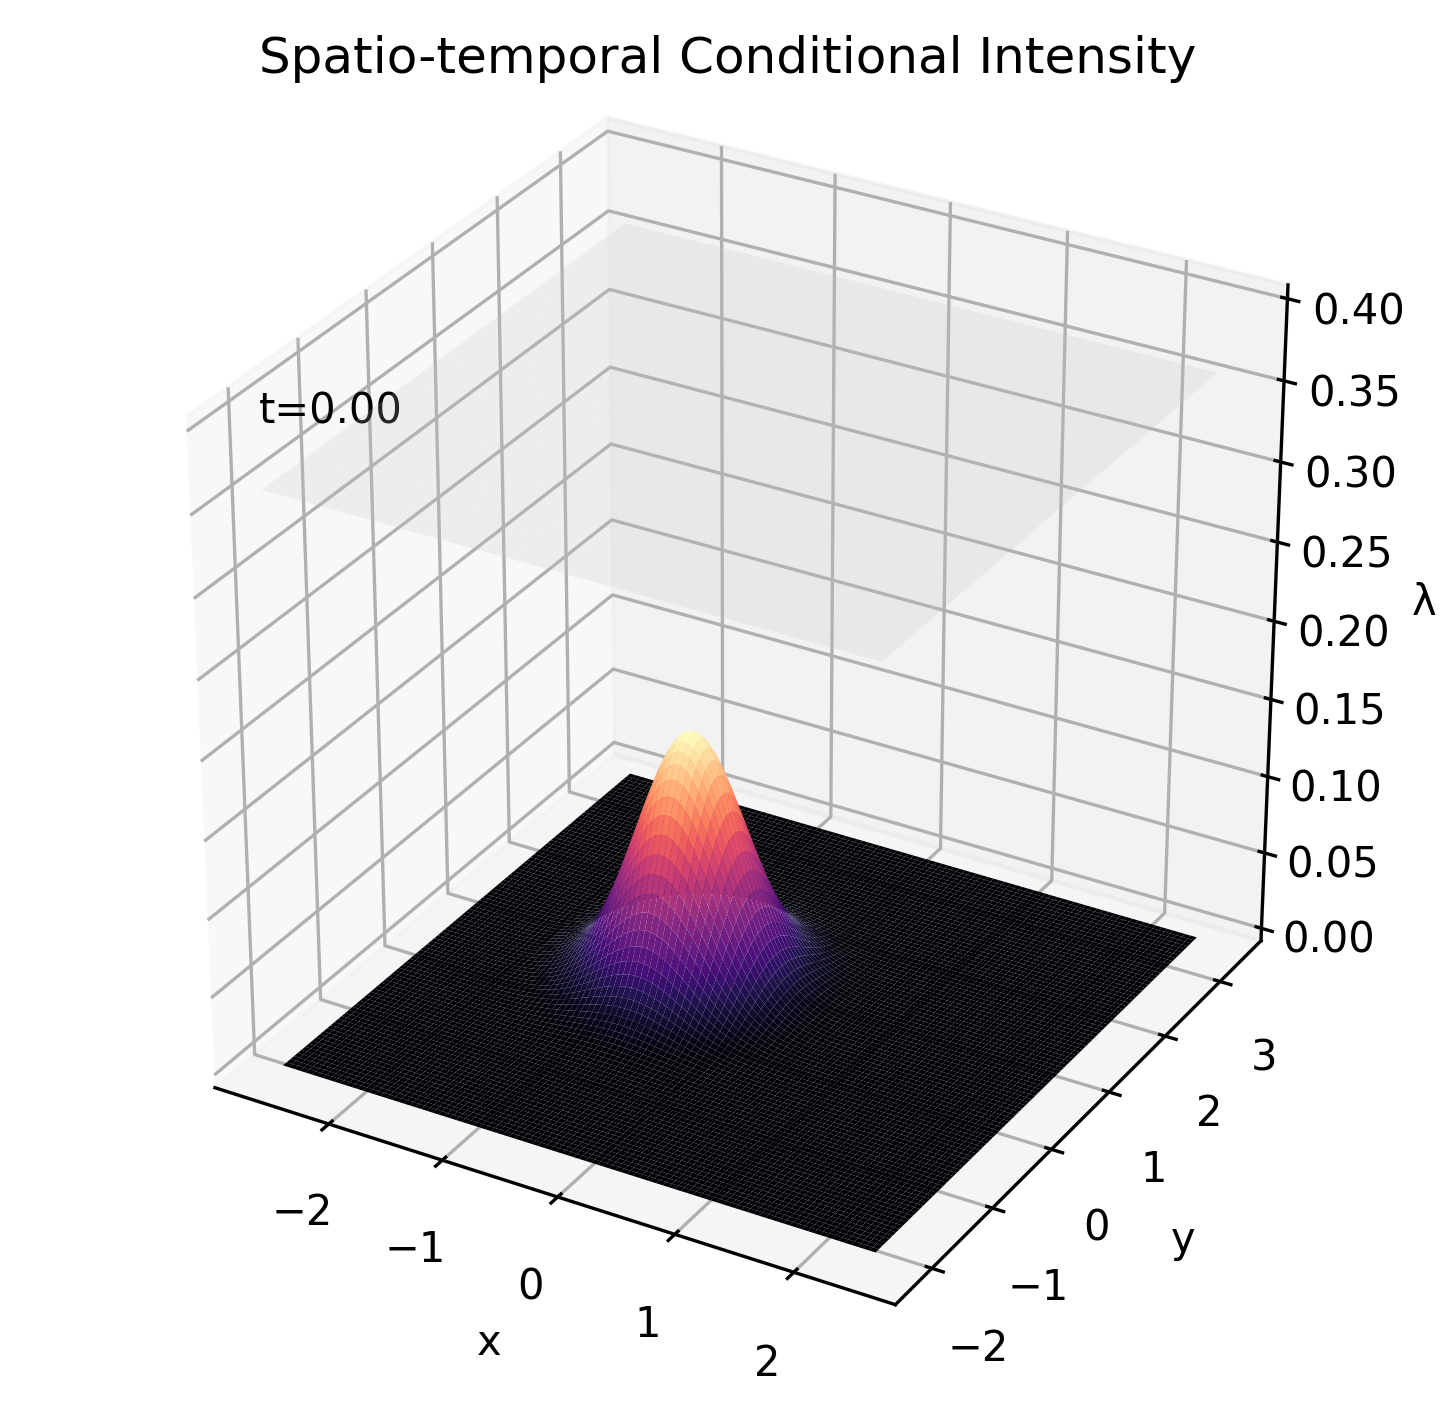

In [11]:
lambs0, x_range, y_range, t_range = sthp0.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=200)
plot_lambst_static(lambs0, x_range, y_range, t_range, history=(sthp0.his_s, sthp0.his_t), fn=f'../video/sthp0_gt.mp4', cmax=0.4, fps=12)

In [17]:
lambs1, x_range, y_range, t_range = sthp1.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=200)
print(x_range[0], x_range[-1])
print(y_range[0], y_range[-1])

  0%|          | 0/201 [00:00<?, ?it/s]

-3.442677 8.523935
-5.453821 6.470327


In [18]:
with open('../data/external/sthp1_gt.npz', 'wb') as f:
    np.savez(f, 
             lambs  =lambs1,
             x_range=x_range,
             y_range=y_range,
             t_range=t_range)

  0%|          | 0/201 [00:00<?, ?it/s]

Inferred cmax: 3.0


  0%|          | 0/203 [00:00<?, ?it/s]

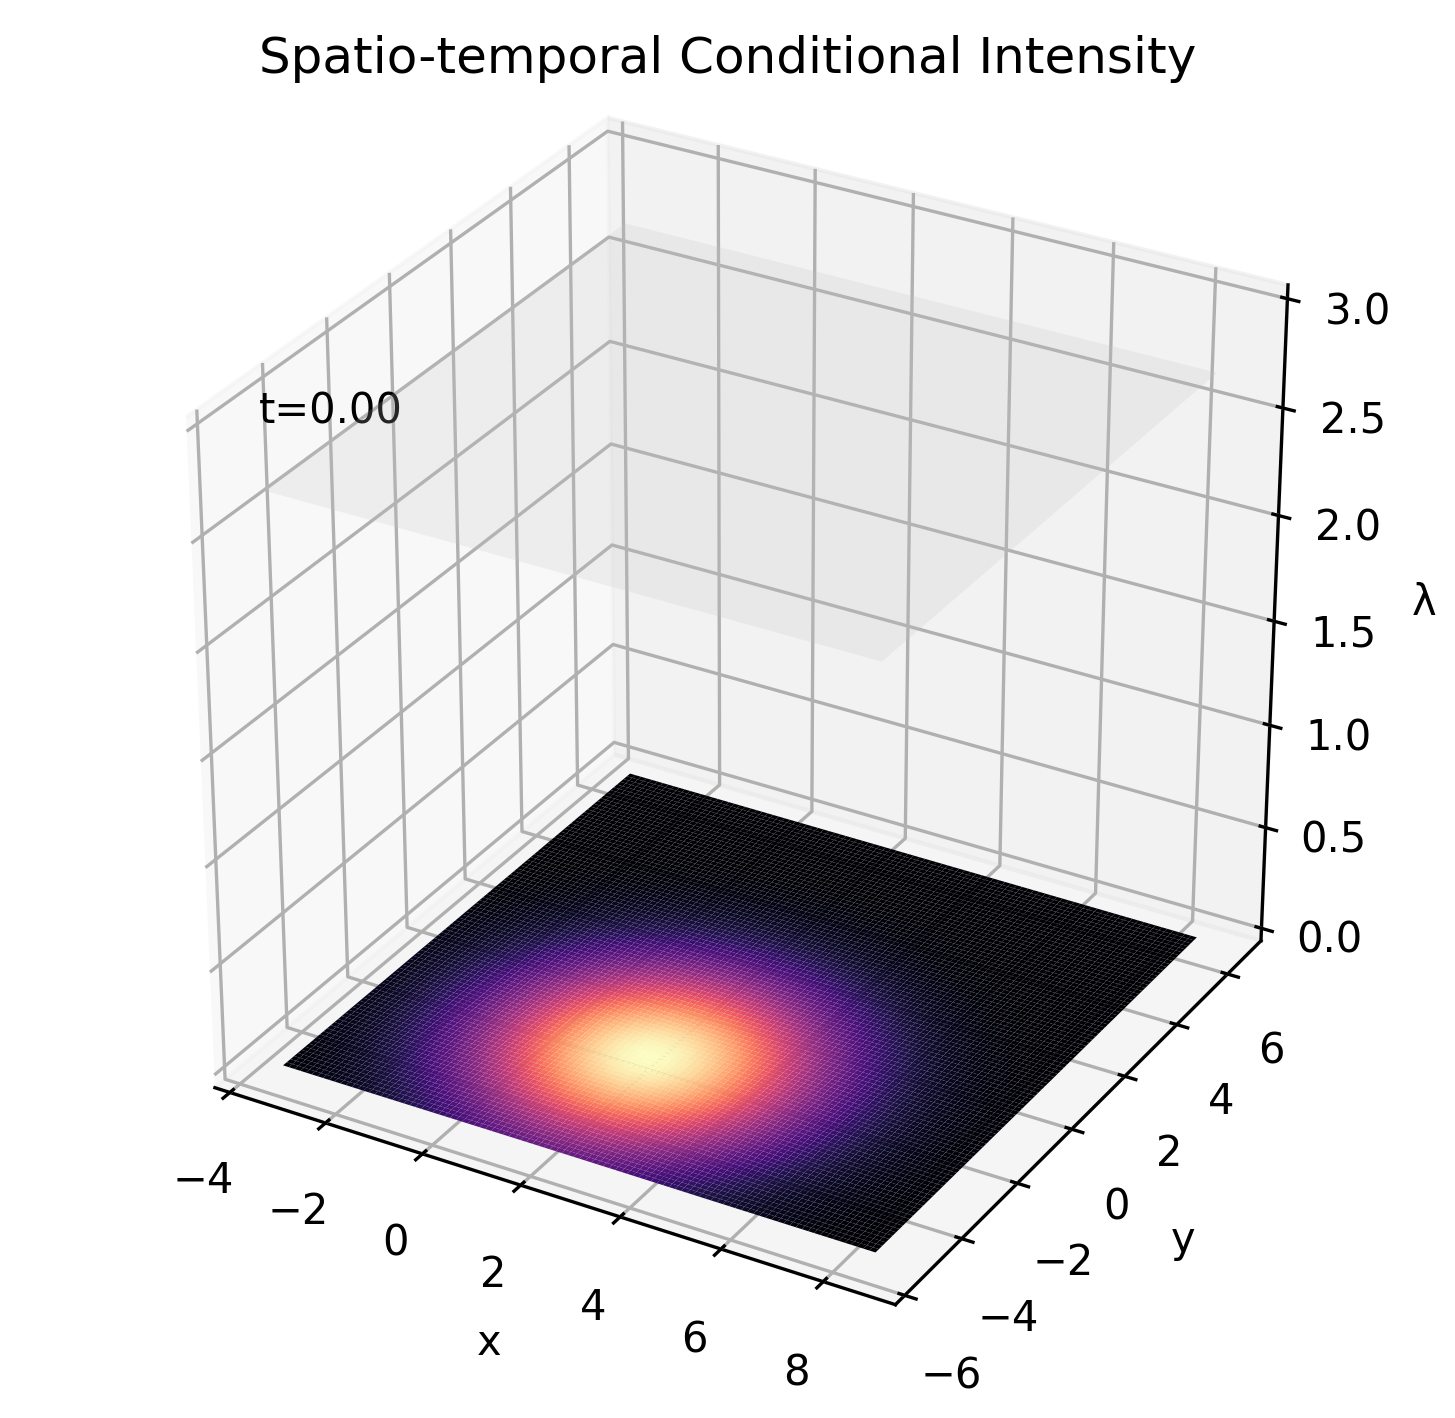

In [12]:
lambs1, x_range, y_range, t_range = sthp1.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=200)
plot_lambst_static(lambs1, x_range, y_range, t_range, history=(sthp1.his_s, sthp1.his_t), fn=f'../video/sthp1_gt.mp4', cmax=3.0, fps=12)

In [19]:
lambs2, x_range, y_range, t_range = sthp2.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=200)
print(x_range[0], x_range[-1])
print(y_range[0], y_range[-1])

  0%|          | 0/201 [00:00<?, ?it/s]

-3.273617 2.202125
-2.807062 2.934222


In [20]:
with open('../data/external/sthp2_gt.npz', 'wb') as f:
    np.savez(f, 
             lambs  =lambs2,
             x_range=x_range,
             y_range=y_range,
             t_range=t_range)

  0%|          | 0/201 [00:00<?, ?it/s]

Inferred cmax: 0.6


  0%|          | 0/203 [00:00<?, ?it/s]

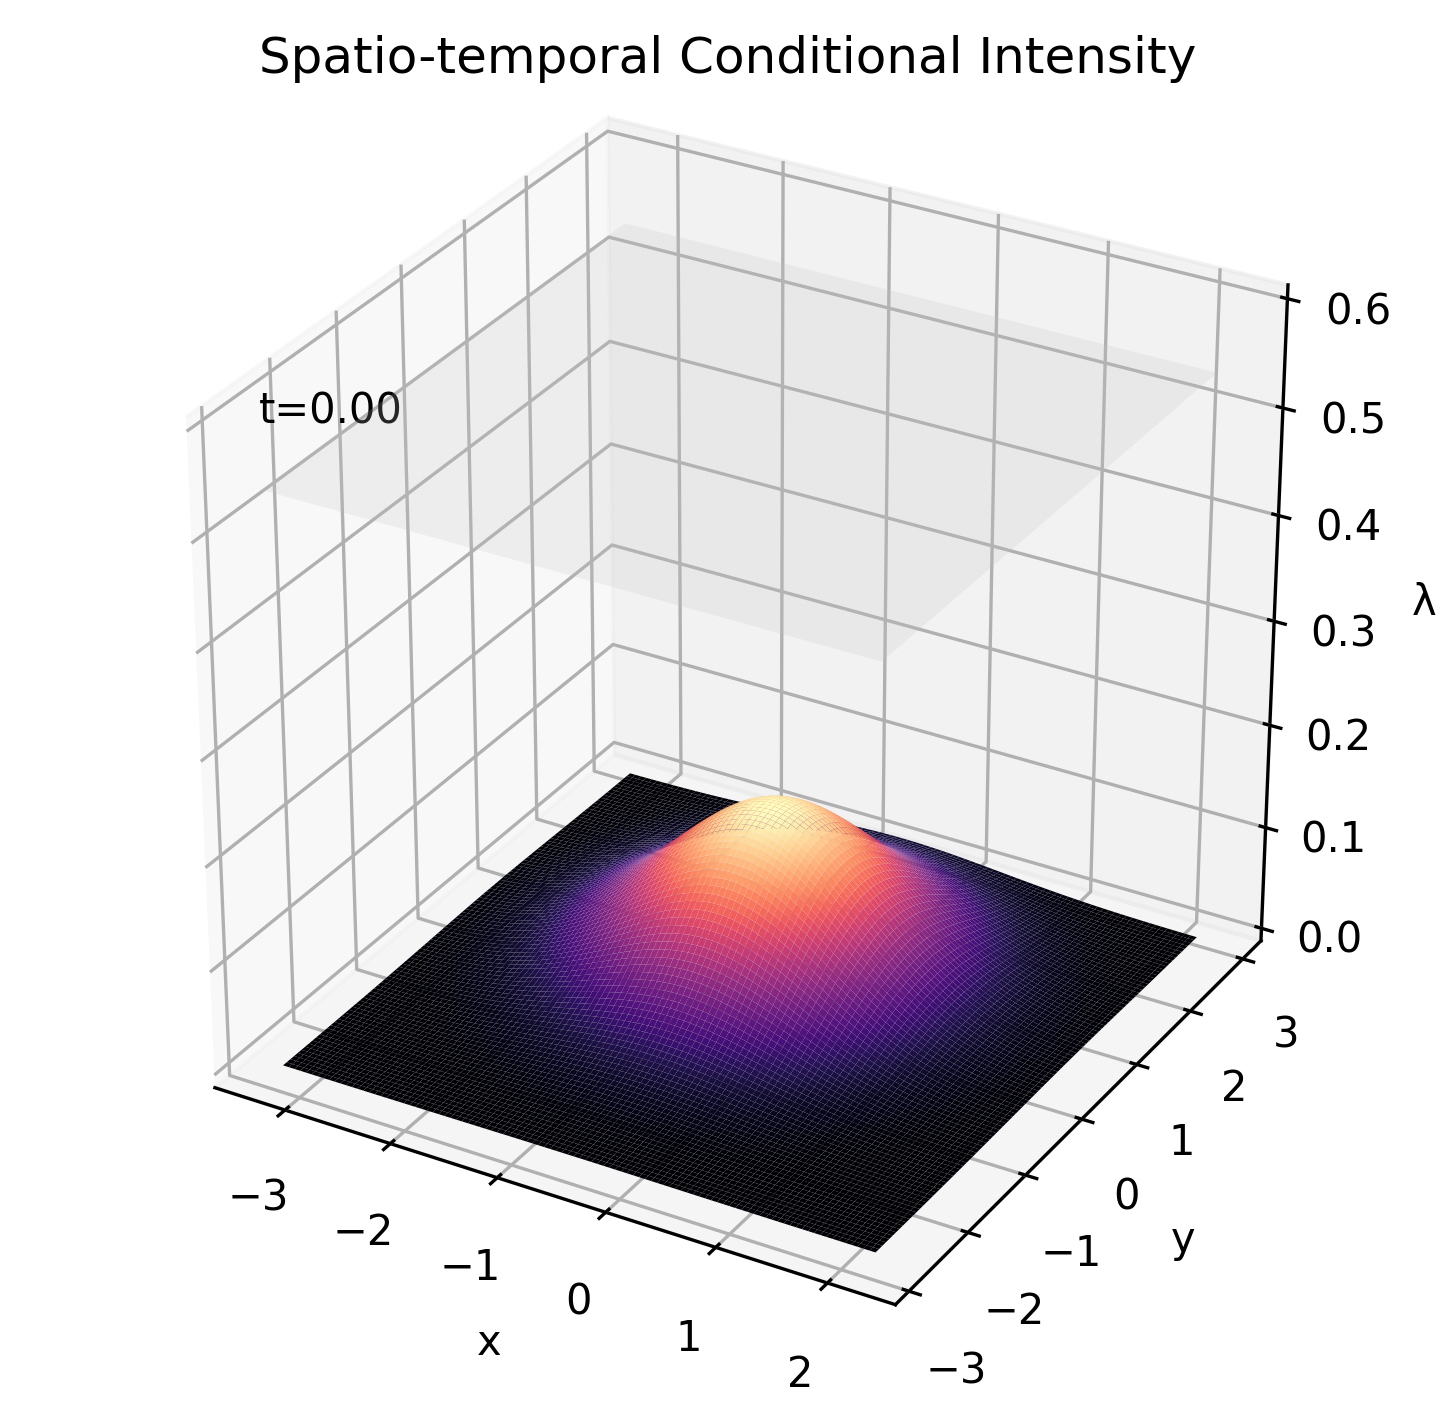

In [7]:
lambs2, x_range, y_range, t_range = sthp2.get_lamb_st(x_num=101, y_num=101, t_num=201, t_start=0, t_end=200)
plot_lambst_static(lambs2, x_range, y_range, t_range, history=(sthp2.his_s, sthp2.his_t), fn=f'../video/sthp2_gt.mp4', cmax=0.6, fps=12)

In [136]:
data = synthetic_split(sthp0.his_s, sthp0.his_t, T=200)
with open('../data/processed/sthp0.npz', 'wb') as f:
    np.savez(f, 
             train=data[10:50],
             test =data[:5],
             val  =data[5:10])
summarize(data)

number of data: 50
sequence length range: 49 ~ 124
time range: 0.004 ~ 199.979
s1 range:   -0.747 ~ 2.390
s2 range:   -1.132 ~ 1.483


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [137]:
data = synthetic_split(sthp1.his_s, sthp1.his_t, T=200)
with open('../data/processed/sthp1.npz', 'wb') as f:
    np.savez(f, 
             train=data[10:50],
             test =data[:5],
             val  =data[5:10])
summarize(data)

number of data: 50
sequence length range: 54 ~ 392
time range: 0.005 ~ 199.989
s1 range:   -3.772 ~ 4.681
s2 range:   -6.389 ~ 5.978


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [138]:
data = synthetic_split(sthp2.his_s, sthp2.his_t, T=200)
with open('../data/processed/sthp2.npz', 'wb') as f:
    np.savez(f, 
             train=data[10:50],
             test =data[:5],
             val  =data[5:10])
summarize(data)

number of data: 50
sequence length range: 190 ~ 284
time range: 0.026 ~ 199.988
s1 range:   -2.754 ~ 2.375
s2 range:   -2.158 ~ 1.786


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



---
## Sliding Window Data Wrapper

In [72]:
sys.path.append("../src")
from data.dataset import SlidingWindowWrapper

In [139]:
npzf = np.load('../data/processed/sthp0.npz', allow_pickle=True)

In [140]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)

In [143]:
print(np.max(sthp0.his_s, 0))
print(np.min(sthp0.his_s, 0))
print(np.max(sthp0.his_t))
print(np.min(sthp0.his_t))

[4.298697 5.108987]
[-4.454281 -4.459622]
9991.348584
9.920166


In [144]:
data = synthetic_split(sthp0.his_s, sthp0.his_t, T=200)
print(np.max(np.vstack(data), 0))
print(np.min(np.vstack(data), 0))

[199.979184   4.298697   5.108987]
[ 4.061000e-03 -4.454281e+00 -4.459622e+00]


In [ ]:
npzf = np.load('../data/processed/covid_nj_cases.npz', allow_pickle=True)

In [ ]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)

In [ ]:
trainset[5]

(tensor([[ 2.1381e-03,  5.2649e-01,  5.2375e-01],
         [ 3.1857e-02,  1.6965e-01,  1.7617e-01],
         [ 1.6373e-02, -3.5150e-01, -6.6210e-01],
         [ 7.4889e-03,  4.8522e-02,  5.3388e-01],
         [ 8.1767e-03, -3.6421e-01,  1.8592e-01],
         [ 1.1614e-01,  3.0520e-01, -3.6993e-01],
         [ 1.1015e-02,  1.5725e-01,  2.5173e-01],
         [ 1.0222e-02, -1.2317e-01, -1.0135e-01],
         [ 4.4313e-04, -2.5725e-01, -3.8685e-01],
         [ 1.1819e-02,  4.2257e-01,  3.5110e-01],
         [ 1.4099e-01, -4.2739e-01, -4.3038e-01],
         [ 9.8571e-04,  8.7860e-03,  3.4413e-02],
         [ 3.5863e-03,  1.6867e-01,  4.2609e-01],
         [ 4.3322e-03,  3.5876e-01, -1.3190e+00],
         [ 1.0296e-02, -2.1048e-02,  1.3788e+00],
         [ 1.6936e-02, -2.3079e-01,  1.5440e-01],
         [ 4.5361e-02, -2.4754e-01,  2.8339e-01],
         [ 4.0353e-03,  5.0158e-01, -4.5478e-01],
         [ 5.6518e-02, -3.0794e-01, -2.7065e-01],
         [ 1.2724e-02, -3.1418e-02,  1.4783e-01]],

In [ ]:
trainset[5]

(tensor([[4.3866e-04, 9.8511e-01, 6.5688e-02],
         [6.5361e-03, 9.8049e-01, 5.7713e-02],
         [3.3593e-03, 9.7374e-01, 3.8478e-02],
         [1.5365e-03, 9.7892e-01, 6.5920e-02],
         [1.6776e-03, 9.7357e-01, 5.7936e-02],
         [2.3829e-02, 9.8224e-01, 4.5182e-02],
         [2.2600e-03, 9.8033e-01, 5.9447e-02],
         [2.0972e-03, 9.7669e-01, 5.1345e-02],
         [9.0905e-05, 9.7496e-01, 4.4794e-02],
         [2.4248e-03, 9.8376e-01, 6.1726e-02],
         [2.8927e-02, 9.7275e-01, 4.3795e-02],
         [2.0223e-04, 9.7840e-01, 5.4460e-02],
         [7.3579e-04, 9.8048e-01, 6.3447e-02],
         [8.8883e-04, 9.8294e-01, 2.3406e-02],
         [2.1125e-03, 9.7802e-01, 8.5307e-02],
         [3.4747e-03, 9.7530e-01, 5.7213e-02],
         [9.3069e-03, 9.7508e-01, 6.0173e-02],
         [8.2792e-04, 9.8479e-01, 4.3235e-02],
         [1.1596e-02, 9.7430e-01, 4.7460e-02],
         [2.6105e-03, 9.7788e-01, 5.7063e-02]], dtype=torch.float64),
 tensor([[0.0020, 0.9840, 0.0270]], d

In [ ]:
trainset.seqs[0][5:26]

array([[ 2.13809892e-03,  5.26493090e-01,  5.23745468e-01],
       [ 3.18566601e-02,  1.69649407e-01,  1.76167560e-01],
       [ 1.63732302e-02, -3.51502500e-01, -6.62099686e-01],
       [ 7.48887849e-03,  4.85222544e-02,  5.33877476e-01],
       [ 8.17665400e-03, -3.64206329e-01,  1.85919692e-01],
       [ 1.16141718e-01,  3.05201962e-01, -3.69934797e-01],
       [ 1.10153953e-02,  1.57249962e-01,  2.51734082e-01],
       [ 1.02216266e-02, -1.23165617e-01, -1.01347167e-01],
       [ 4.43132696e-04, -2.57249598e-01, -3.86853868e-01],
       [ 1.18185715e-02,  4.22573955e-01,  3.51095874e-01],
       [ 1.40987347e-01, -4.27391367e-01, -4.30383236e-01],
       [ 9.85713841e-04,  8.78600452e-03,  3.44130551e-02],
       [ 3.58630635e-03,  1.68671358e-01,  4.26090729e-01],
       [ 4.33217040e-03,  3.58761071e-01, -1.31896545e+00],
       [ 1.02962280e-02, -2.10479456e-02,  1.37878695e+00],
       [ 1.69356092e-02, -2.30791552e-01,  1.54399402e-01],
       [ 4.53614986e-02, -2.47536084e-01

In [ ]:
print(len(trainset.seqs[0]))
print(trainset.seqs[0][-10:])
print(trainset.seqs[1][:10])

242
[[ 5.51585109e-02  2.05459187e-01  2.85530493e-01]
 [ 2.23093311e-02 -8.87795189e-02 -1.12789884e+00]
 [ 6.25311612e-04 -1.33017955e-01  9.11276968e-01]
 [ 3.45981576e-02  6.55930702e-02  1.97288148e-01]
 [ 5.41678134e-02 -2.76433256e-03 -3.92265287e-02]
 [ 2.92017181e-02  5.40712524e-02 -1.58925702e-01]
 [ 2.20841133e-03  1.21071405e-02  4.59555320e-01]
 [ 7.57046667e-02  2.04323588e-01 -8.17412282e-01]
 [ 2.58667297e-02  4.89522043e-02  6.50715158e-01]
 [ 1.89603113e-02 -2.91267107e-01 -4.74461953e-01]]
[[ 3.18307520e-02 -7.40899879e+01  4.09848417e+01]
 [ 3.70338835e-04  1.85559116e-02 -2.90952381e-01]
 [ 2.06729779e-02  2.24294901e-01 -3.82156758e-01]
 [ 1.22211978e-02 -6.07292991e-01  3.63385230e-01]
 [ 1.59297017e-03  5.40503751e-02 -1.05361540e-01]
 [ 1.54463680e-02  1.63968094e-01  3.01197208e-02]
 [ 2.57620723e-02  6.42198487e-02  3.27657829e-01]
 [ 8.54392271e-03  1.36468471e-02 -2.10290651e-01]
 [ 5.06333713e-03 -4.66838180e-01 -1.64813778e+00]
 [ 2.00881532e-02  5.50298

In [ ]:
trainset[221]

(tensor([[5.6304e-03, 9.8654e-01, 4.9774e-02],
         [3.0577e-03, 9.7918e-01, 5.9661e-02],
         [6.5402e-03, 9.8336e-01, 3.5067e-02],
         [1.0838e-02, 9.7070e-01, 6.5623e-02],
         [1.0918e-03, 9.8042e-01, 6.0428e-02],
         [3.2831e-03, 9.8128e-01, 5.2763e-02],
         [1.3809e-03, 9.7588e-01, 5.3428e-02],
         [4.9260e-03, 9.7462e-01, 4.0820e-02],
         [1.8188e-02, 9.7943e-01, 5.4896e-02],
         [8.5910e-04, 9.7219e-01, 5.2665e-02],
         [1.4430e-03, 9.8429e-01, 5.9797e-02],
         [1.1317e-02, 9.8095e-01, 6.0222e-02],
         [4.5772e-03, 9.7714e-01, 2.7790e-02],
         [1.2828e-04, 9.7657e-01, 7.4580e-02],
         [7.0985e-03, 9.7914e-01, 5.8197e-02],
         [1.1114e-02, 9.7825e-01, 5.2770e-02],
         [5.9914e-03, 9.7899e-01, 5.0024e-02],
         [4.5309e-04, 9.7845e-01, 6.4215e-02],
         [1.5532e-02, 9.8094e-01, 3.4914e-02],
         [5.3071e-03, 9.7892e-01, 6.8601e-02]], dtype=torch.float64),
 tensor([[0.0039, 0.9745, 0.0428]], d

In [ ]:
trainset[222]

(tensor([[6.5308e-03, 1.8622e-02, 9.9409e-01],
         [7.5969e-05, 9.7853e-01, 4.6994e-02],
         [4.2415e-03, 9.8120e-01, 4.4902e-02],
         [2.5074e-03, 9.7042e-01, 6.2008e-02],
         [3.2682e-04, 9.7899e-01, 5.1253e-02],
         [3.1691e-03, 9.8041e-01, 5.4362e-02],
         [5.2856e-03, 9.7912e-01, 6.1189e-02],
         [1.7530e-03, 9.7847e-01, 4.8845e-02],
         [1.0388e-03, 9.7224e-01, 1.5853e-02],
         [4.1215e-03, 9.8542e-01, 9.3944e-02],
         [1.3350e-03, 9.7946e-01, 5.4891e-02],
         [3.2478e-03, 9.7455e-01, 6.0265e-02],
         [1.8590e-03, 9.8154e-01, 1.9024e-02],
         [2.2205e-04, 9.8045e-01, 5.5631e-02],
         [3.5552e-04, 9.7802e-01, 5.4112e-02],
         [2.0709e-04, 9.7339e-01, 8.3526e-02],
         [7.7817e-03, 9.7627e-01, 5.4891e-02],
         [1.0470e-02, 9.8170e-01, 4.7919e-02],
         [1.2584e-03, 9.7505e-01, 5.8092e-02],
         [3.6338e-03, 9.7977e-01, 4.1127e-02]], dtype=torch.float64),
 tensor([[0.0074, 0.9791, 0.0360]], d